In [166]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv('titanic.csv')

In [24]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
# Basic overview
df.info()
df.describe(include="all")

# Missing values summary
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [156]:
features = ["Pclass", "Sex", "Embarked", "SibSp", "Parch"]

for col in features:
    display(df.groupby(col)["Survived"].mean().to_frame("Survival Rate"))

,Survival Rate
Pclass,
1,0.629630
2,0.472826
3,0.242363


,Survival Rate
Sex,
female,0.742038
male,0.188908


,Survival Rate
Embarked,
C,0.553571
Q,0.389610
S,0.339009


,Survival Rate
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


,Survival Rate
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


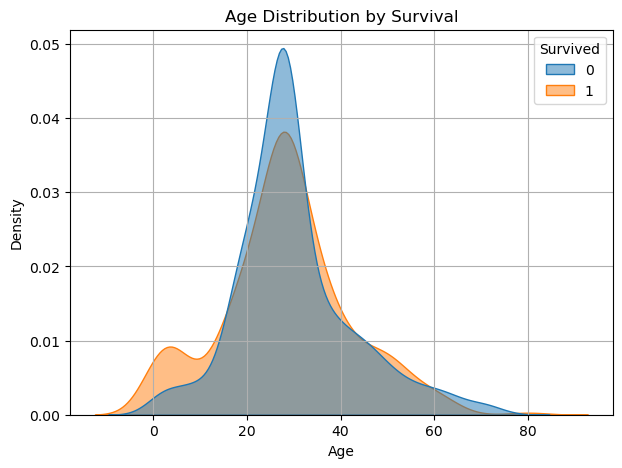

In [172]:
plt.figure(figsize=(7,5))
sns.kdeplot(data=df, x="Age", hue="Survived", fill=True, common_norm=False, alpha=0.5)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Density")
plt.grid(True)
plt.savefig("age_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

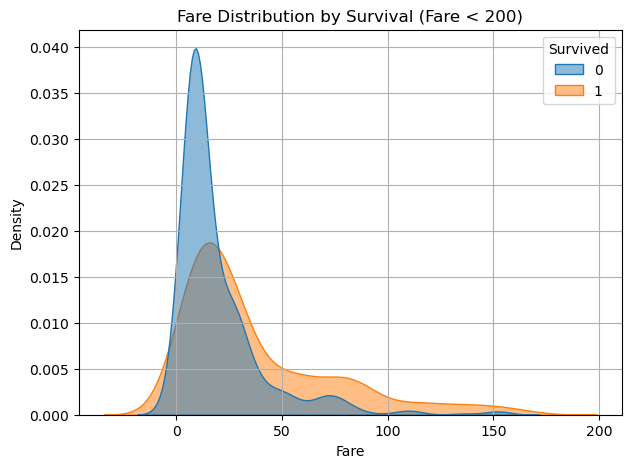

In [174]:
plt.figure(figsize=(7,5))
sns.kdeplot(data=df[df["Fare"] < 200], x="Fare", hue="Survived", fill=True, common_norm=False, alpha=0.5)
plt.title("Fare Distribution by Survival (Fare < 200)")
plt.xlabel("Fare")
plt.grid(True)
plt.savefig("fare_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

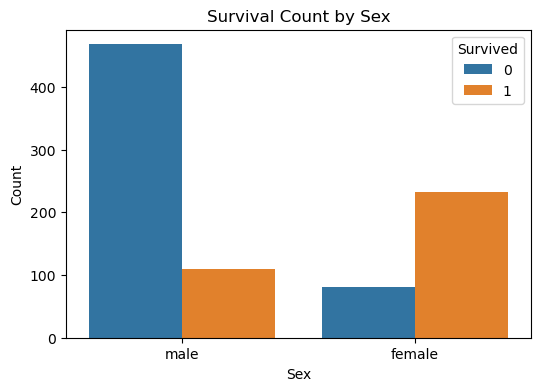

In [176]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title("Survival Count by Sex")
plt.ylabel("Count")
plt.savefig("survival_by_sex.png", dpi=300, bbox_inches='tight')
plt.show()

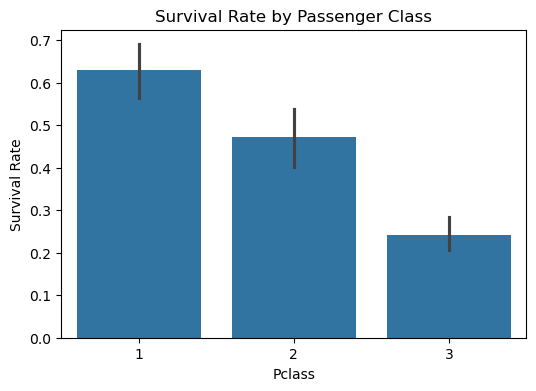

In [178]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["Pclass"], y=df["Survived"])
plt.title("Survival Rate by Passenger Class")
plt.ylabel("Survival Rate")
plt.savefig("survival_by_pclass.png", dpi=300, bbox_inches='tight')
plt.show()

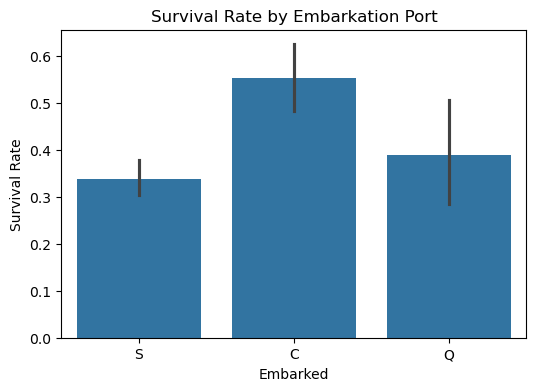

In [180]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="Embarked", y="Survived")
plt.title("Survival Rate by Embarkation Port")
plt.ylabel("Survival Rate")
plt.savefig("survival_by_embarked.png", dpi=300, bbox_inches='tight')
plt.show()

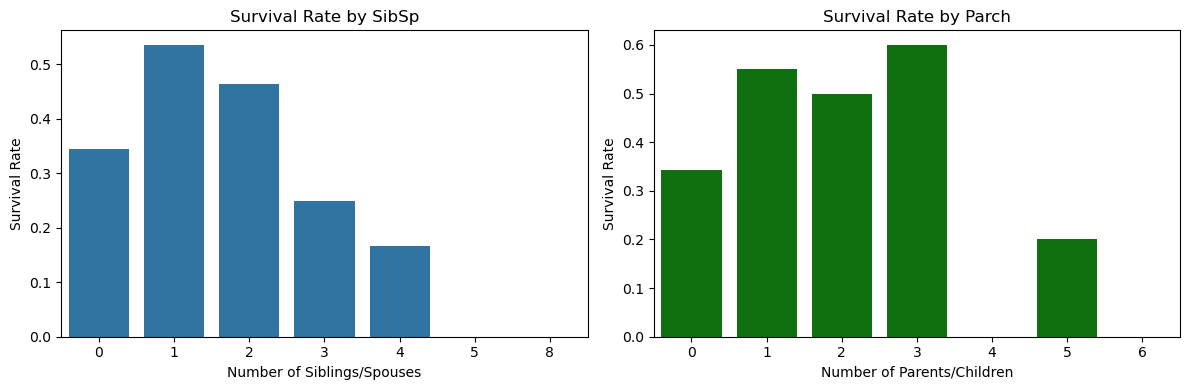

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(
    x=df.groupby("SibSp")["Survived"].mean().index,
    y=df.groupby("SibSp")["Survived"].mean().values,
    ax=axes[0]
)
axes[0].set_title("Survival Rate by SibSp")
axes[0].set_xlabel("Number of Siblings/Spouses")
axes[0].set_ylabel("Survival Rate")

sns.barplot(
    x=df.groupby("Parch")["Survived"].mean().index,
    y=df.groupby("Parch")["Survived"].mean().values,
    ax=axes[1],
    color='green'
)
axes[1].set_title("Survival Rate by Parch")
axes[1].set_xlabel("Number of Parents/Children")
axes[1].set_ylabel("Survival Rate")

plt.tight_layout()
plt.savefig("survival_by_sibsp_parch.png", dpi=300, bbox_inches='tight')
plt.show()

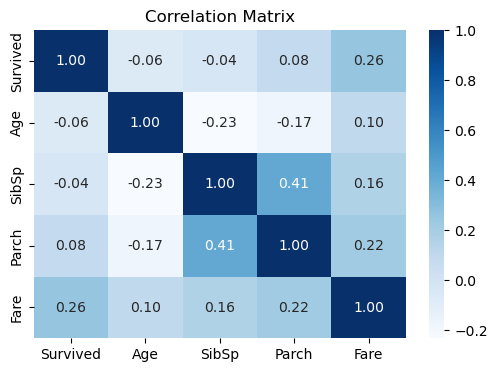

In [184]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["Survived","Age","SibSp","Parch","Fare"]].corr(),
            annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig("corr_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

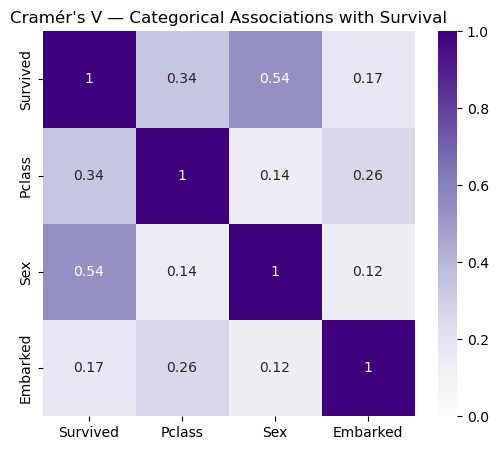

In [186]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(r - 1, k - 1)))

categorical_cols = ["Survived", "Pclass", "Sex", "Embarked"]

cramer_matrix = pd.DataFrame(
    np.zeros((len(categorical_cols), len(categorical_cols))),
    index=categorical_cols,
    columns=categorical_cols
)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(6,5))
sns.heatmap(cramer_matrix, annot=True, cmap="Purples", vmin=0, vmax=1)
plt.title("Cramér's V — Categorical Associations with Survival")
plt.savefig("cramer_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

###  Visual EDA: Survival Patterns Analysis

To better understand which passengers had a higher probability of survival, we analyzed survival rates across the main demographic and socio-economic features:

- **Sex**  
  Females survived at a much higher rate than males, reflecting the historical **“women and children first”** evacuation policy.

- **Passenger Class (Pclass)**  
  Survival increases strongly with class: 1st-class passengers survived significantly more often than 2nd and 3rd class due to **better physical access to lifeboats**.

- **Fare (ticket price)**  
  Higher ticket prices correlate with higher survival, reinforcing the socio-economic advantage already visible through Pclass.

- **Age**  
  Younger passengers had a higher chance of survival.

- **Family structure (SibSp & Parch)**  
  Survival is **lowest** among people traveling alone or in very large families.  
  Passengers with **small families (1–2 close relatives)** had the best survival rates, suggesting **mutual assistance** during rescue.

- **Port of Embarkation (Embarked)**  
  Shows weaker effects overall, but passengers departing from port **C (Cherbourg)** had slightly higher survival rates.

- **Correlation heatmap** confirms that Fare carry important information,
  while SibSp and Parch show weaker but noticeable patterns.

- **Cramer's-V heatmap** confirms that Sex and Pclass carry important information,
  while Embarked is less important feature.


###  Data preprocessing

In [40]:
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
df = df.drop(columns=cols_to_drop)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [46]:
# Features with missing values: Age, Embarked

# Age: fill with median
df["Age"] = df["Age"].fillna(df["Age"].median())

# Embarked: fill with mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Double-check
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [48]:
categorical_cols = ["Sex", "Embarked", "Pclass"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,True,False,True,False,True
1,1,38.0,1,0,71.2833,False,False,False,False,False
2,1,26.0,0,0,7.9250,False,False,True,False,True
3,1,35.0,1,0,53.1000,False,False,True,False,False
4,0,35.0,0,0,8.0500,True,False,True,False,True


### Train/Test and Model Baseline

In [54]:
# split train and test datasets for dependent variable 'Survived'
X = df_encoded.drop(columns=["Survived"])
y = df_encoded["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((712, 9), (179, 9))

In [64]:
# Train Decision Tree baseline
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8156424581005587

Confusion matrix:
 [[94 16]
 [17 52]]

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [109]:
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

Tree depth: 20
Number of leaves: 156


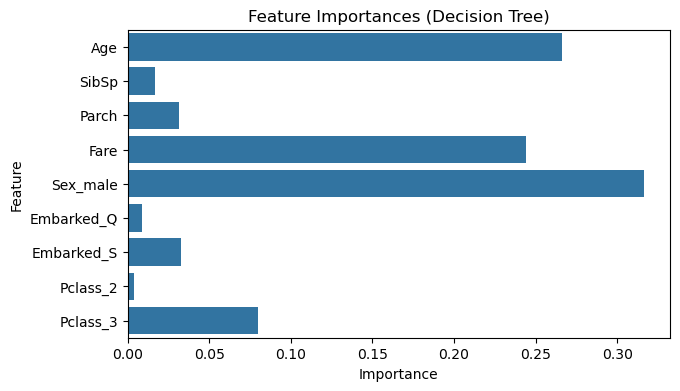

Sex_male      0.316638
Age           0.266301
Fare          0.243906
Pclass_3      0.080186
Embarked_S    0.032543
Parch         0.031285
SibSp         0.016714
Embarked_Q    0.008729
Pclass_2      0.003698
dtype: float64

In [81]:
# Feature Importance

feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(7,4))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("feature_importances.png", dpi=300, bbox_inches='tight')
plt.show()

feature_importances.sort_values(ascending=False)

### Interpretation of Feature Importances

The decision tree identifies **Sex (male/female)** as the most influential predictor of survival — reflecting the historical “women and children first” evacuation rule.  
**Age** also plays a strong role: younger passengers had a higher chance of survival.  
The tree assigns high importance to the indicator for 3rd class (**Pclass_3**), meaning that being in 3rd class provides strong information for distinguishing survivors from non-survivors.  
This does not mean that 3rd class increases surval — rather the opposite: 3rd-class passengers historically had much lower survival rates, and the model uses this strong negative signal for splitting.  
Consequently, **Fare** and **Pclass** capture socio-economic status, where higher-class passengers had better access to lifeboats.  
Family-related features (**SibSp**, **Parch**) contribute less but still provide useful information about group survival patterns.  
**Embarked** also shows minimal importance.


In [107]:
# Experimental evaluation of the model performance for different tree depths
# to detect underfitting (too shallow) vs overfitting (too deep)
# Depth values tested: 2, 4, 6, and None (unrestricted depth)

depths = [2, 4, 6, None]
results = {}

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    
    results[d] = acc
    print(f"Depth={d}: accuracy = {acc:.4f}")


Depth=2: accuracy = 0.7598
Depth=4: accuracy = 0.7989
Depth=6: accuracy = 0.8045
Depth=None: accuracy = 0.8156


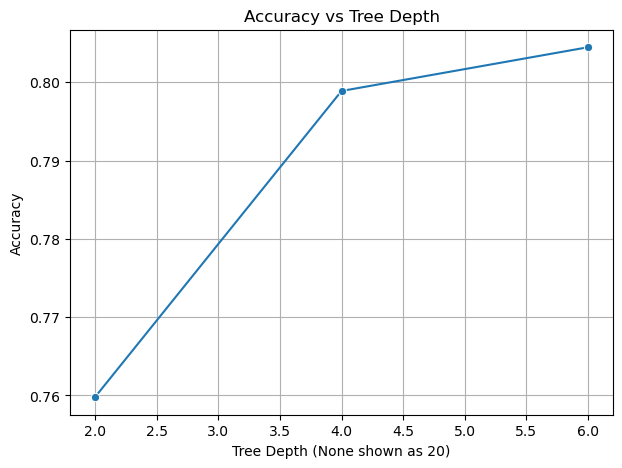

In [188]:
# Convert results dict to a DataFrame for plotting
results_df = pd.DataFrame({
    "depth": [2, 4, 6, None],
    "accuracy": [results[2], results[4], results[6], results[None]]
})

# Replace None with a numeric placeholder for plotting (e.g., max_depth = 20)
results_df["depth_plot"] = results_df["depth"].replace({None: 20})

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df, x="depth_plot", y="accuracy", marker="o")
plt.title("Accuracy vs Tree Depth")
plt.xlabel("Tree Depth (None shown as 20)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("tree_depth_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

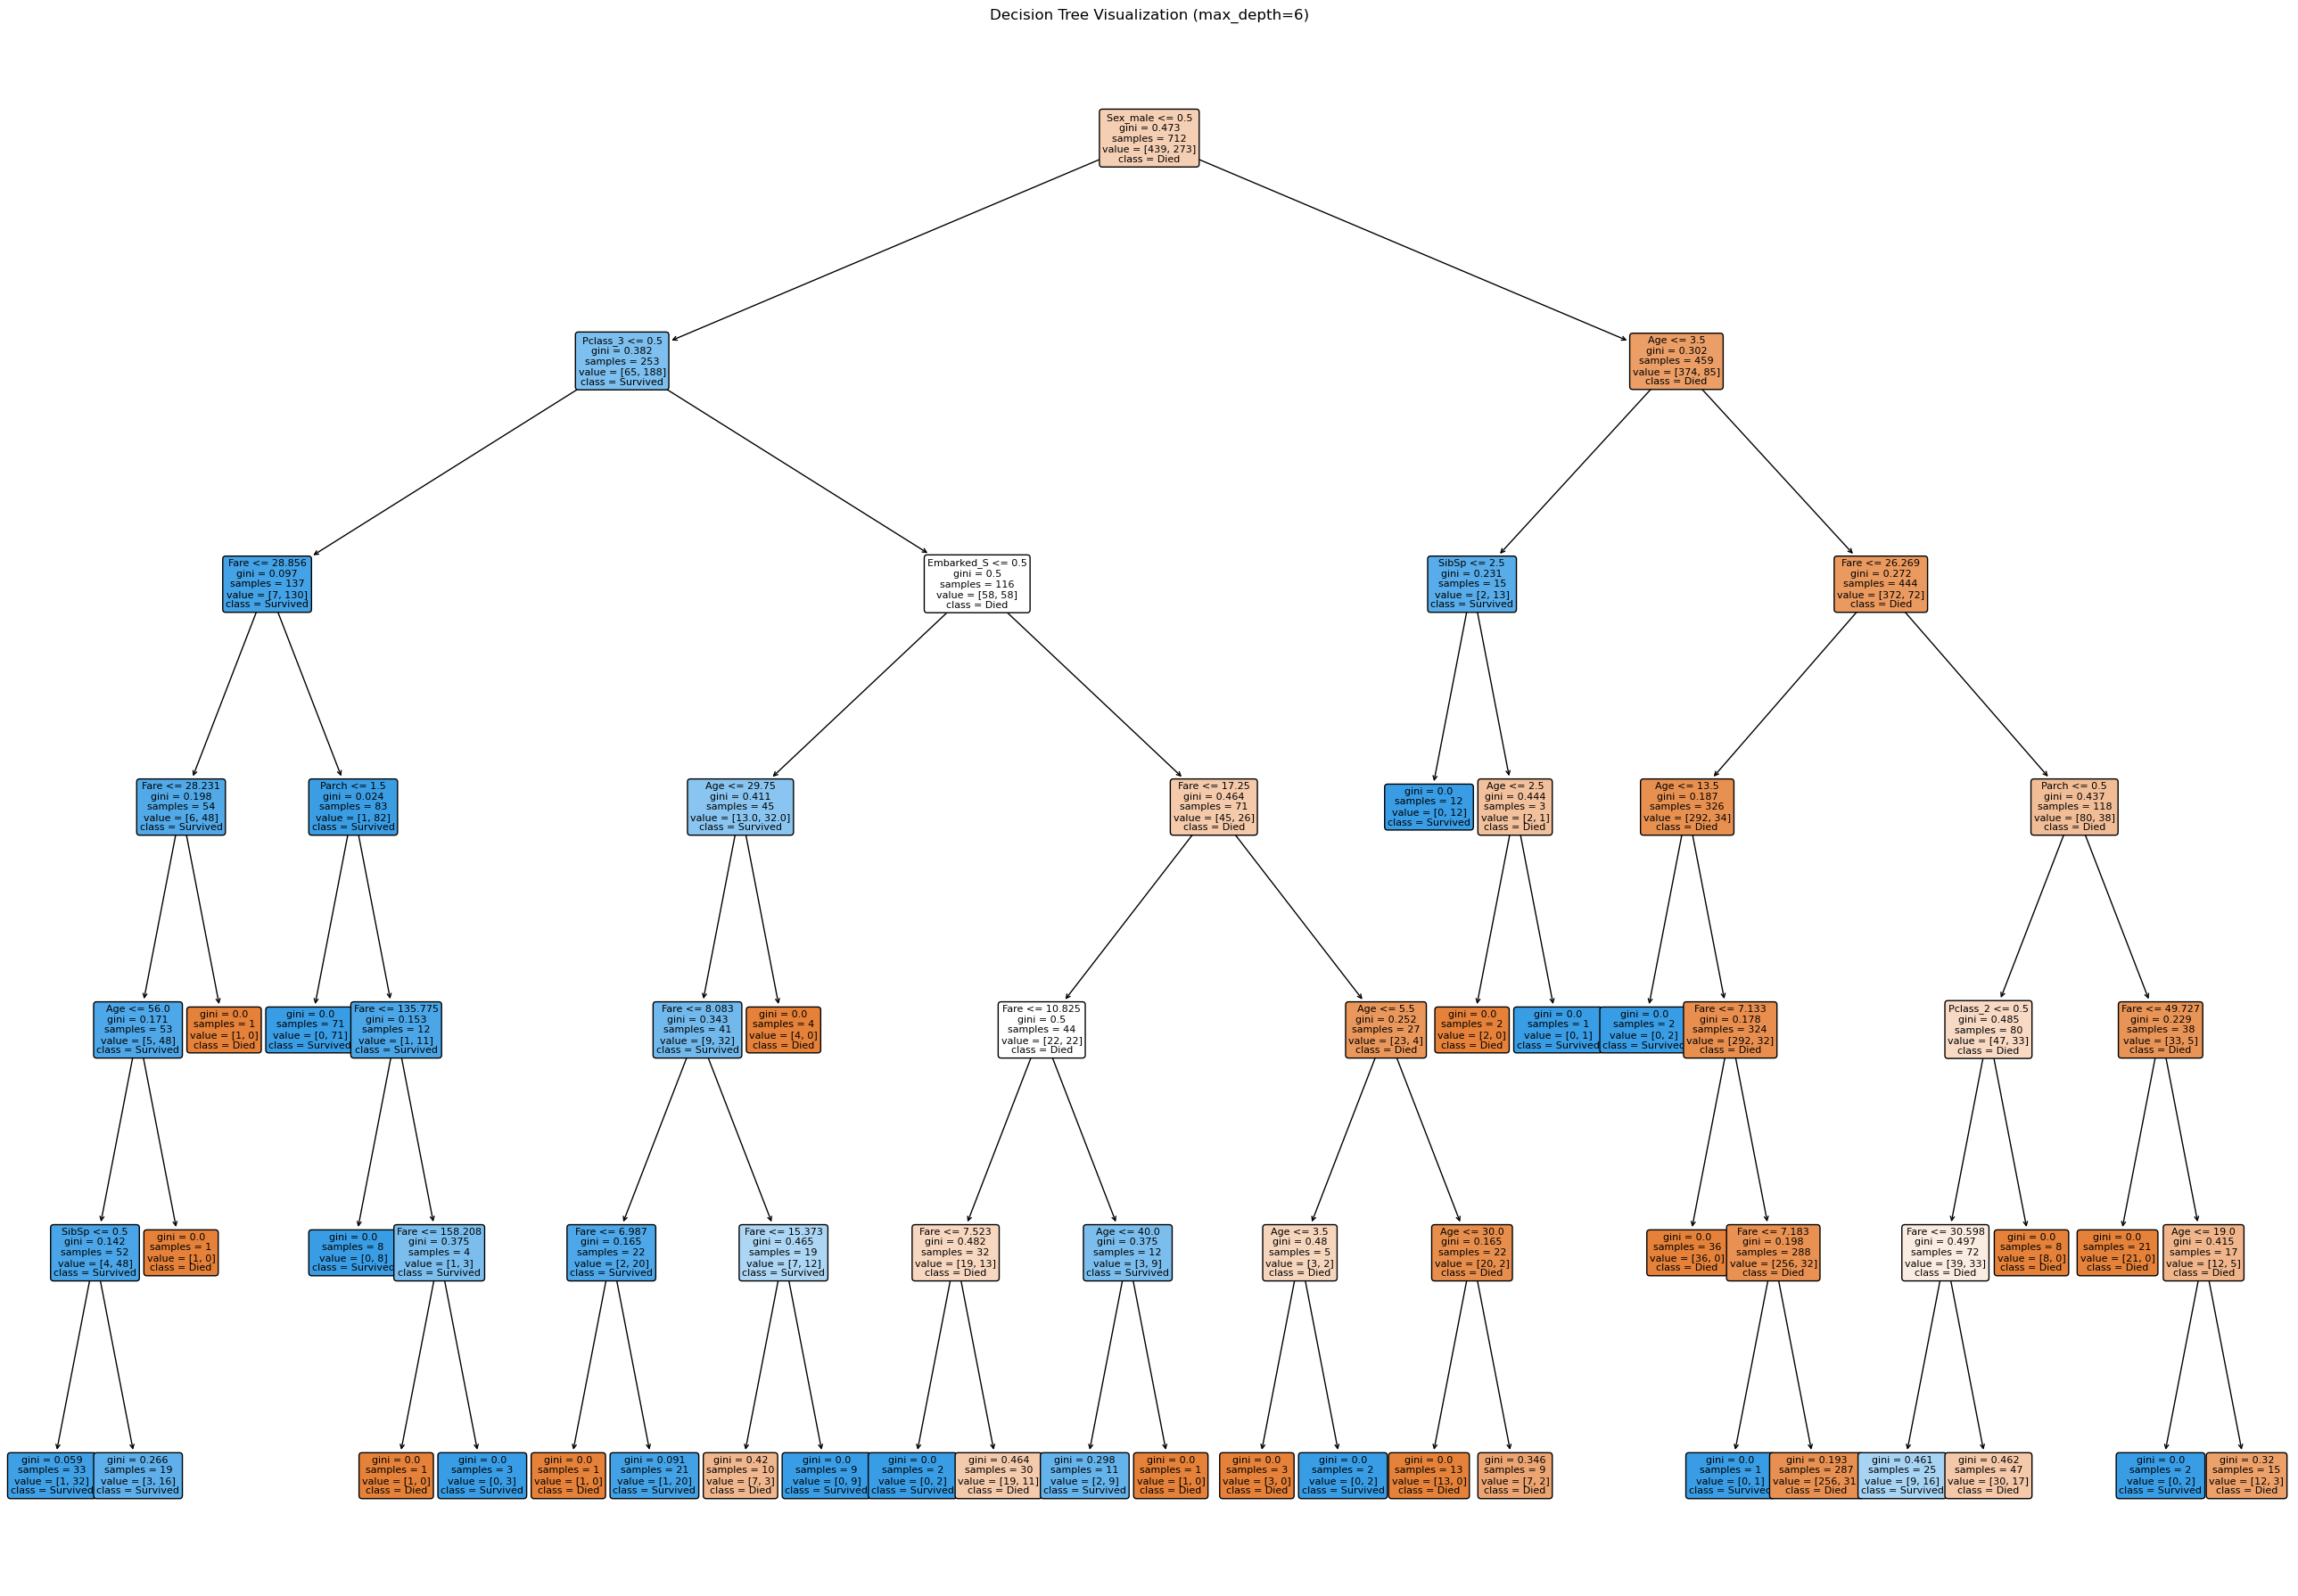

In [168]:
# Visualize the optimal Decision Tree (max_depth=6)
opt_clf = DecisionTreeClassifier(max_depth=6, random_state=42)
opt_clf.fit(X_train, y_train)

plt.figure(figsize=(26, 18))
tree.plot_tree(
    opt_clf,
    feature_names=X_train.columns,
    class_names=["Died", "Survived"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Visualization (max_depth=6)")
plt.tight_layout()
plt.savefig("decision_tree_depth6.png", dpi=200, bbox_inches="tight")
plt.show()

## Interpretation of Depth Experiment Results

Testing different values of `max_depth` shows a clear pattern in model behavior:

- **Depth = 2** yields the lowest accuracy (0.7598), indicating **underfitting** — the model is too simple and cannot capture the structure of the data.
- **Depth = 4** improves accuracy (0.7989), but the decision boundary remains not expressive enough.
- **Depth = 6** performs better (0.8045), suggesting a more optimal balance between complexity and generalization.
- **Depth = None** (unrestricted depth) provides the highest accuracy (0.8156).  
  This means that, for the Titanic dataset, deeper trees still capture meaningful interactions between features without strong overfitting on the test set.

Overall, increasing tree depth reduces underfitting. In this experiment, the **unrestricted-depth tree performed best**, indicating that the model benefits from additional depth on this dataset.


## FamilySize feature experiment

To evaluate whether combining SibSp and Parch into a single feature improves predictive power,  
we create a new feature:

**FamilySize = SibSp + Parch + 1**

We then repeat the full modeling pipeline (encoding → split → training → evaluation) and compare the results with the baseline decision tree.


In [207]:
# Create a copy so we don't overwrite the main processed dataset
df_fs = df.copy()

# Add FamilySize
df_fs["FamilySize"] = df_fs["SibSp"] + df_fs["Parch"] + 1

In [201]:
df_fs.groupby("FamilySize")["Survived"].mean().to_frame("Survival Rate")

,Survival Rate
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


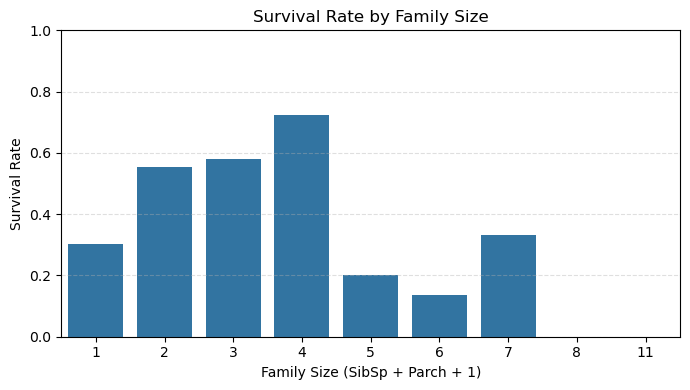

In [203]:
# Bar chart: Survival Rate by Family Size
family_survival = df_fs.groupby("FamilySize")["Survived"].mean()

plt.figure(figsize=(7,4))
sns.barplot(
    x=family_survival.index,
    y=family_survival.values
)

plt.title("Survival Rate by Family Size")
plt.xlabel("Family Size (SibSp + Parch + 1)")
plt.ylabel("Survival Rate")
plt.ylim(0,1)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("family_size_survival.png", dpi=300, bbox_inches="tight")
plt.show()

In [209]:
# Encode categorical variables
categorical_cols = ["Sex", "Embarked", "Pclass"]
df_fs_encoded = pd.get_dummies(df_fs, columns=categorical_cols, drop_first=True)

In [211]:
# Train-test split
X_fs = df_fs_encoded.drop(columns=["Survived"])
y_fs = df_fs_encoded["Survived"]

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_fs, y_fs, test_size=0.2, random_state=42, stratify=y_fs
)

In [213]:
# Train new Decision Tree
clf_fs = DecisionTreeClassifier(random_state=42)
clf_fs.fit(X_train_fs, y_train_fs)

y_pred_fs = clf_fs.predict(X_test_fs)

print("Accuracy with FamilySize:", accuracy_score(y_test_fs, y_pred_fs))
print("\nConfusion matrix:\n", confusion_matrix(y_test_fs, y_pred_fs))
print("\nClassification report:\n", classification_report(y_test_fs, y_pred_fs))

Accuracy with FamilySize: 0.7877094972067039

Confusion matrix:
 [[92 18]
 [20 49]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



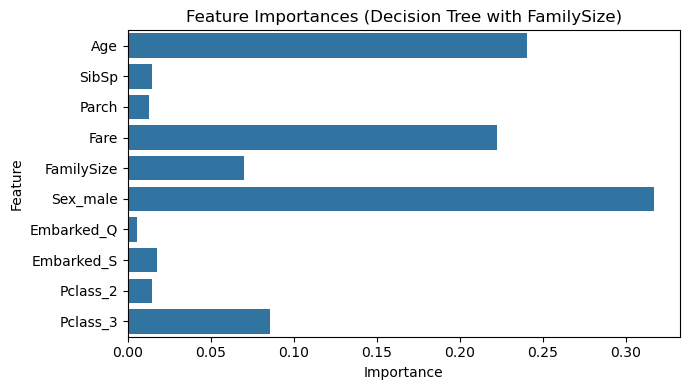

Sex_male      0.316638
Age           0.240340
Fare          0.222386
Pclass_3      0.085729
FamilySize    0.069880
Embarked_S    0.017595
SibSp         0.014539
Pclass_2      0.014436
Parch         0.012846
Embarked_Q    0.005611
dtype: float64

In [195]:
feature_importances_fs = pd.Series(clf_fs.feature_importances_, index=X_train_fs.columns)

plt.figure(figsize=(7,4))
sns.barplot(
    x=feature_importances_fs.values,
    y=feature_importances_fs.index
)
plt.title("Feature Importances (Decision Tree with FamilySize)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

feature_importances_fs.sort_values(ascending=False)

### Interpretation of FamilySize Experiment

FamilySize appears among the top features, this confirms that the model benefits
from summarizing SibSp and Parch into a single group-related indicator.

Comparing accuracy with and without FamilySize allows us to quantify this improvement.


In [198]:
depths = [2, 4, 6, None]
results_fs = {}

for d in depths:
    model_fs = DecisionTreeClassifier(max_depth=d, random_state=42)
    model_fs.fit(X_train_fs, y_train_fs)
    pred_fs = model_fs.predict(X_test_fs)
    acc_fs = accuracy_score(y_test_fs, pred_fs)
    results_fs[d] = acc_fs
    print(f"Depth={d}: accuracy = {acc_fs:.4f}")

Depth=2: accuracy = 0.7598
Depth=4: accuracy = 0.7989
Depth=6: accuracy = 0.7933
Depth=None: accuracy = 0.7877


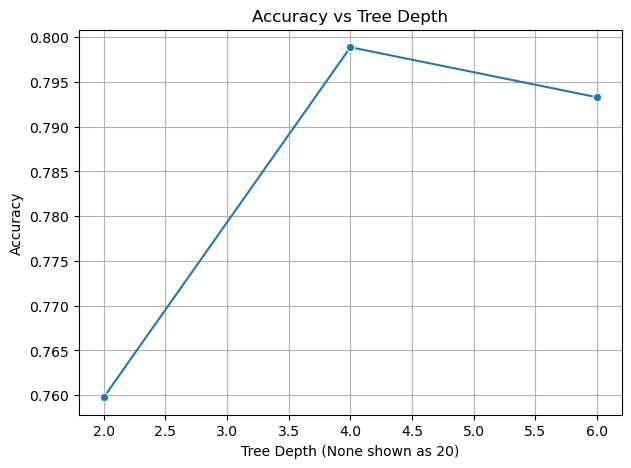

In [215]:
# Convert results dict to a DataFrame for plotting
results_df_fs = pd.DataFrame({
    "depth": [2, 4, 6, None],
    "accuracy": [results_fs[2], results_fs[4], results_fs[6], results_fs[None]]
})

# Replace None with a numeric placeholder for plotting (e.g., max_depth = 20)
results_df_fs["depth_plot"] = results_df_fs["depth"].replace({None: 20})

plt.figure(figsize=(7,5))
sns.lineplot(data=results_df_fs, x="depth_plot", y="accuracy", marker="o")
plt.title("Accuracy vs Tree Depth")
plt.xlabel("Tree Depth (None shown as 20)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("tree_depth_accuracy_fs.png", dpi=300, bbox_inches='tight')
plt.show()

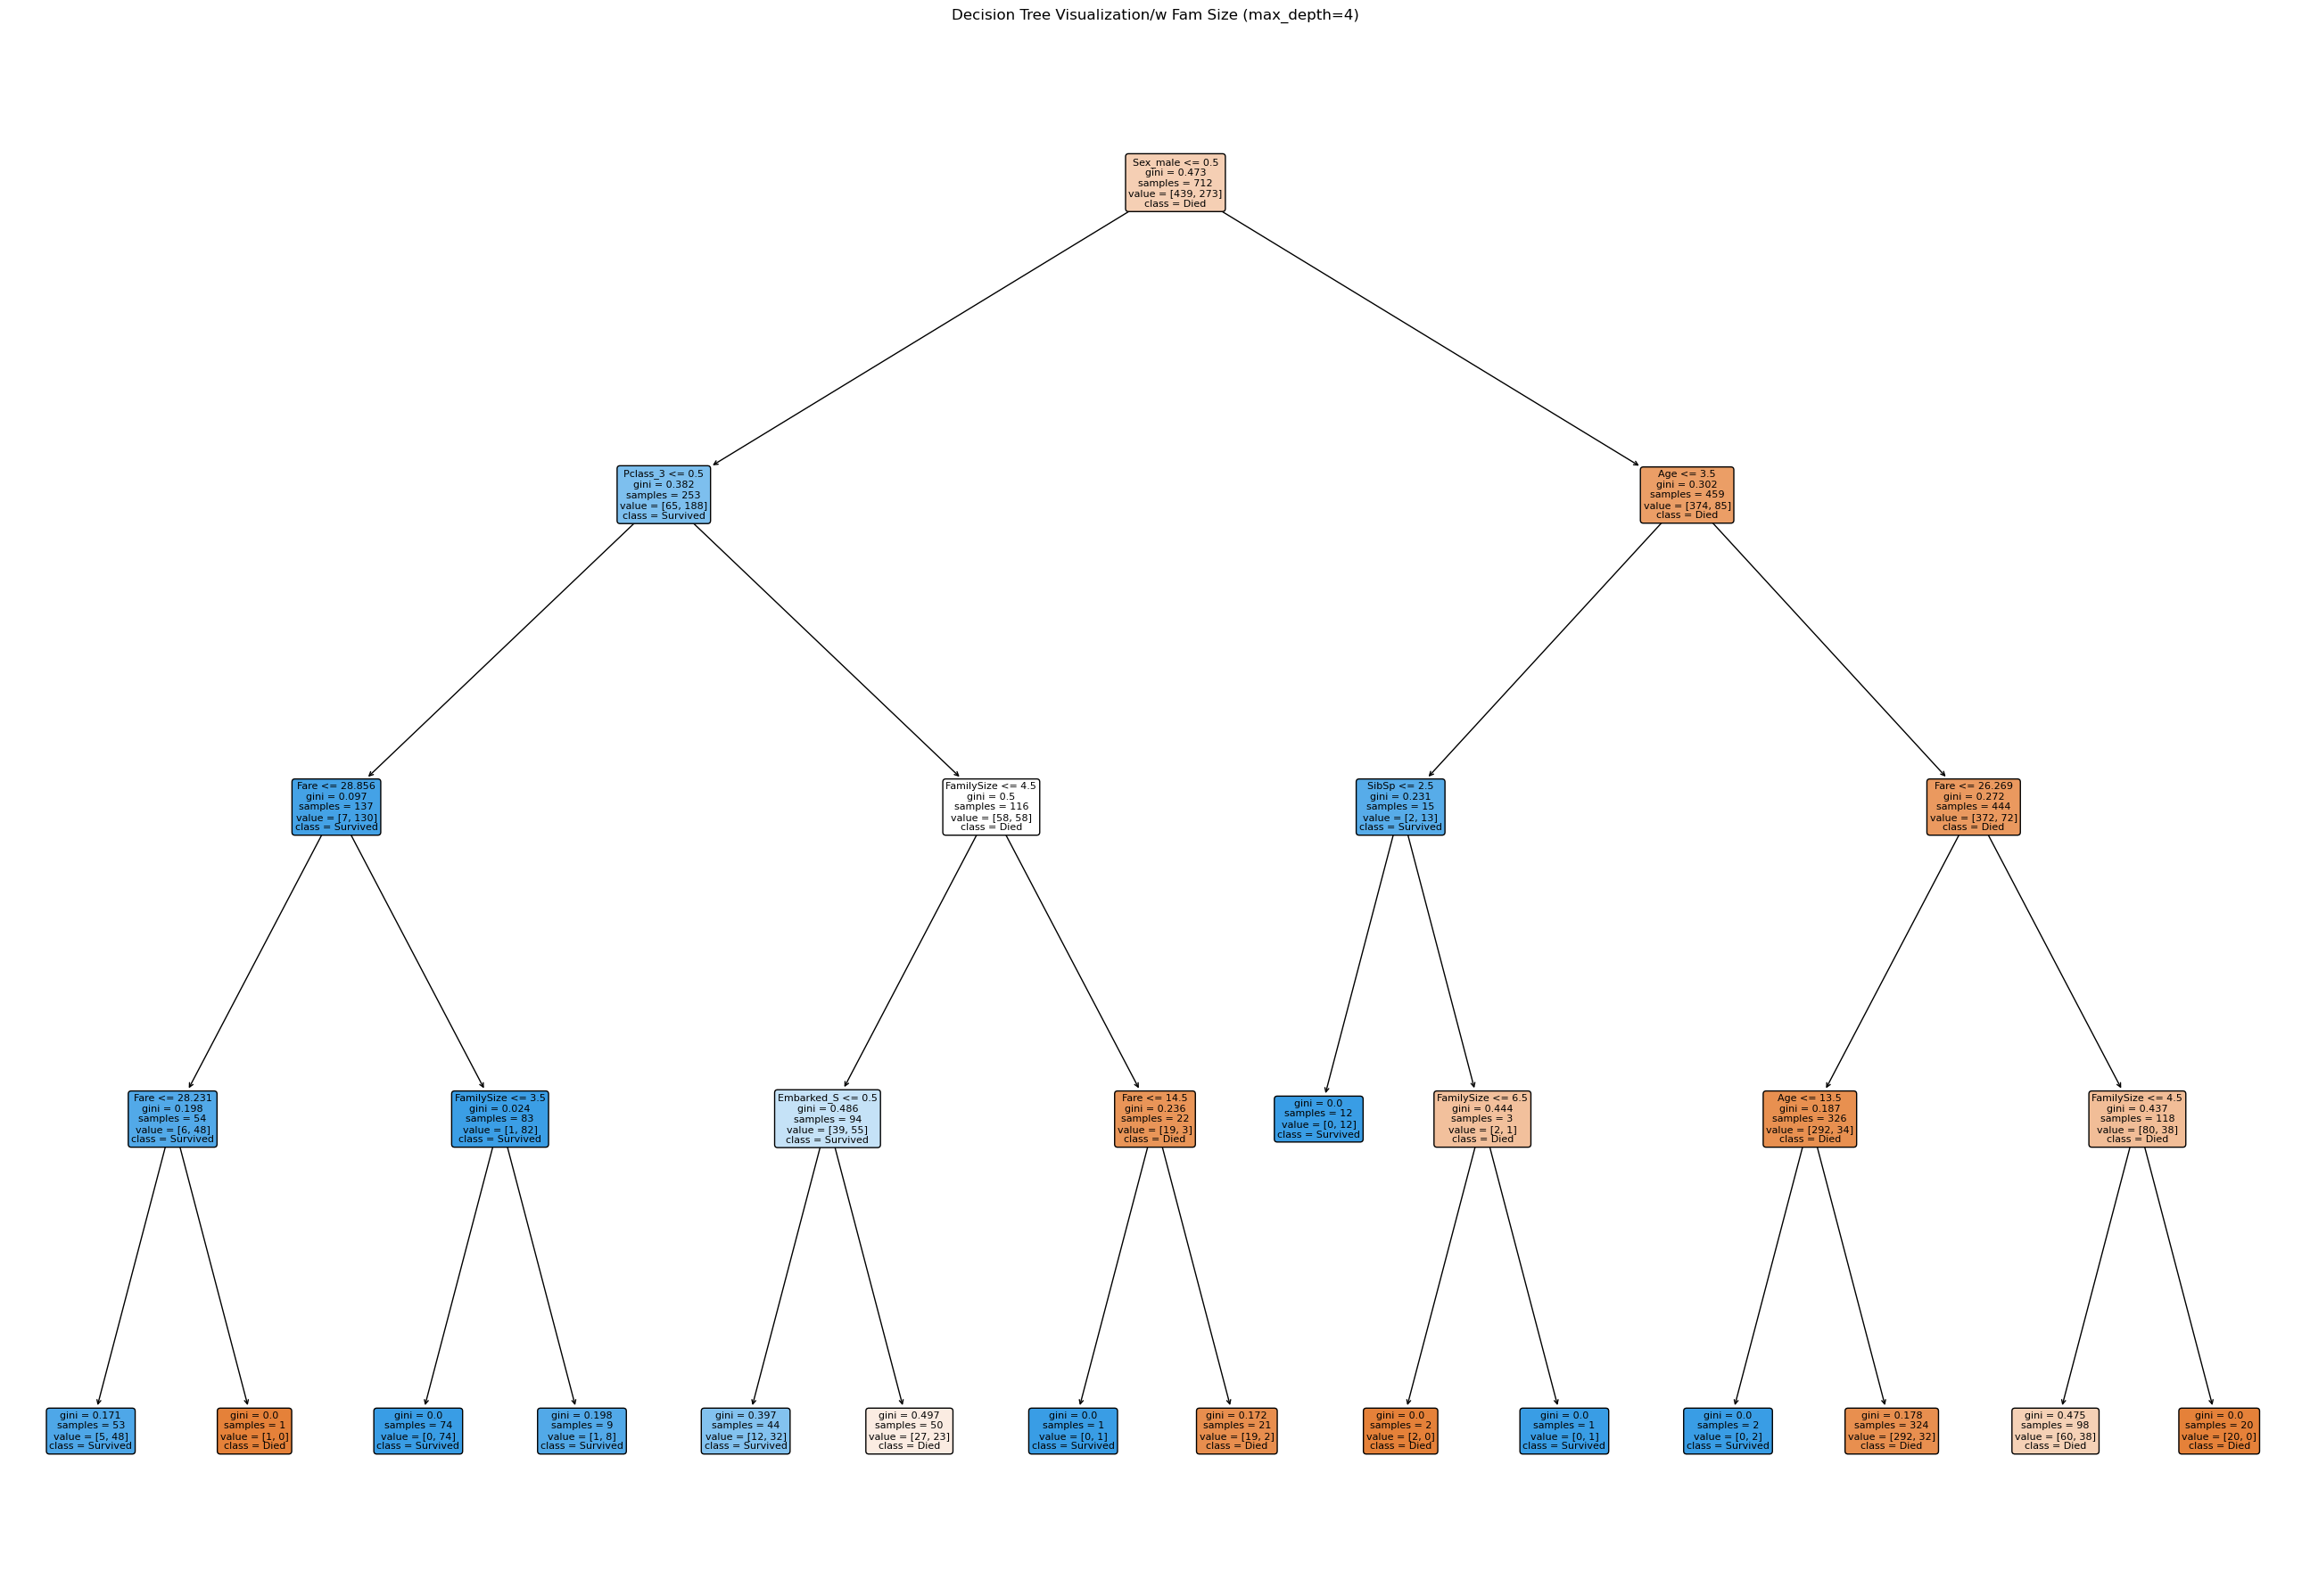

In [217]:
# Visualize the optimal Decision Tree (max_depth=6)
opt_clf_fs = DecisionTreeClassifier(max_depth=4, random_state=42)
opt_clf_fs.fit(X_train_fs, y_train_fs)

plt.figure(figsize=(26, 18))
tree.plot_tree(
    opt_clf_fs,
    feature_names=X_train_fs.columns,
    class_names=["Died", "Survived"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree Visualization/w Fam Size (max_depth=4)")
plt.tight_layout()
plt.savefig("decision_tree_fs_depth4.png", dpi=200, bbox_inches="tight")
plt.show()

### Interpretation of FamilySize Experiment

The `FamilySize` feature captures an intuitive pattern in the data:  
small families (2–4 people) have noticeably higher survival rates,  
while very large families almost never survive. This is clearly visible  
in the survival-rate table and the bar plot.

However, when we add `FamilySize` on top of the original features (`SibSp` and `Parch`)
and repeat the depth experiment, the model’s accuracy does **not** improve:

- previously the best accuracy was around **0.8156** (unrestricted depth),
- with `FamilySize` the best accuracy is about **0.799** (at depth = 4),
- deeper trees (depth = 6 or None) no longer provide any gain and even perform worse.

This suggests that the tree already exploited family-structure information using `SibSp`
and `Parch`, and the aggregated `FamilySize` feature does not bring a new independent
signal. Instead, it introduces additional correlation and slightly destabilizes the
decision boundary.

In summary, `FamilySize` is useful for **exploratory analysis** and interpretation,
but in this particular Decision Tree configuration it **does not improve** preictive
performance.
